<a href="https://colab.research.google.com/github/pradeeps1111/DataScience_Assignments/blob/main/Hackathon_1/Copy_of_Hackathon_credit_analysis_21_10_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Assessment in Fintech Industry

# Libraries Needed

In [ ]:


import pandas as pd
import numpy as np
import re
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

##EDA##
import matplotlib.pyplot as plt
import seaborn as sns

##Preprocess
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

#job lib
import joblib

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score










# Load Dataset

In [ ]:
train = pd.read_csv("/content/train_loan_data.csv")
test = pd.read_csv("/content/test_loan_data.csv")




In [ ]:
print("Train data: {} features and {} observations".format(train.shape[1],train.shape[0]))
print("Test data: {} features and {} observations".format(test.shape[1],test.shape[0]))

Train data: 28 features and 30004 observations
Test data: 27 features and 20000 observations


# Checking For Duplicates

In [ ]:
train.duplicated().sum()
test.duplicated().sum()

0

# Merging train and test data

In [ ]:
data = pd.concat([train,test])
data.head(2)

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status
0,CO,85000.0,Jul-1997,10+ years,Deputy,744.0,740.0,E,MORTGAGE,Individual,...,0.0,debt_consolidation,5338.0,93.6,E1,60 months,Debt consolidation,8.0,Source Verified,Charged Off
1,CA,40000.0,Apr-1987,10+ years,Department of Veterans Affairs,724.0,720.0,B,RENT,Individual,...,0.0,debt_consolidation,19944.0,60.3,B1,36 months,Credit Loan,12.0,Verified,Fully Paid


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50004 entries, 0 to 19999
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   addr_state            50004 non-null  object 
 1   annual_inc            50004 non-null  float64
 2   earliest_cr_line      50004 non-null  object 
 3   emp_length            47009 non-null  object 
 4   emp_title             46742 non-null  object 
 5   fico_range_high       50003 non-null  float64
 6   fico_range_low        50003 non-null  float64
 7   grade                 50003 non-null  object 
 8   home_ownership        50003 non-null  object 
 9   application_type      50003 non-null  object 
 10  initial_list_status   50003 non-null  object 
 11  int_rate              50003 non-null  float64
 12  loan_amnt             50003 non-null  float64
 13  num_actv_bc_tl        47494 non-null  float64
 14  mort_acc              48250 non-null  float64
 15  tot_cur_bal        

In [ ]:
data.head(10)

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status
0,CO,85000.0,Jul-1997,10+ years,Deputy,744.0,740.0,E,MORTGAGE,Individual,...,0.0,debt_consolidation,5338.0,93.6,E1,60 months,Debt consolidation,8.0,Source Verified,Charged Off
1,CA,40000.0,Apr-1987,10+ years,Department of Veterans Affairs,724.0,720.0,B,RENT,Individual,...,0.0,debt_consolidation,19944.0,60.3,B1,36 months,Credit Loan,12.0,Verified,Fully Paid
2,FL,60000.0,Aug-2007,10+ years,Marble polishing,679.0,675.0,B,MORTGAGE,Individual,...,0.0,debt_consolidation,23199.0,88.5,B5,36 months,Debt consolidation,16.0,Source Verified,Fully Paid
3,IL,100742.0,Sep-1980,10+ years,printer,664.0,660.0,B,MORTGAGE,Individual,...,0.0,debt_consolidation,18425.0,69.0,B2,36 months,Debt consolidation,19.0,Source Verified,Fully Paid
4,MD,80000.0,Jul-1999,10+ years,Southern Mgmt,669.0,665.0,F,RENT,Individual,...,0.0,debt_consolidation,34370.0,90.0,F5,60 months,Debt Connsolidation,59.0,Verified,Fully Paid
5,CA,51488.0,May-1991,NaN,NaN,679.0,675.0,D,MORTGAGE,Individual,...,0.0,home_improvement,10747.0,53.9,D3,36 months,Home improvement,37.0,Verified,Fully Paid
6,NY,100000.0,Oct-1986,10+ years,RN,699.0,695.0,C,MORTGAGE,Individual,...,0.0,credit_card,32488.0,54.1,C1,36 months,Credit card refinancing,36.0,Verified,Fully Paid
7,PA,35028.0,Nov-1995,3 years,SHHC,679.0,675.0,C,RENT,Individual,...,0.0,debt_consolidation,13147.0,78.3,C4,36 months,Credit consolidation sought,19.0,Not Verified,Fully Paid
8,FL,59292.0,Dec-2007,NaN,NaN,664.0,660.0,B,MORTGAGE,Individual,...,0.0,debt_consolidation,1054.0,23.4,B4,36 months,NaN,23.0,Verified,Fully Paid
9,CA,65000.0,Jun-2004,< 1 year,Nurse,684.0,680.0,D,RENT,Individual,...,0.0,debt_consolidation,8991.0,64.7,D4,36 months,Debt consolidation,20.0,Source Verified,Fully Paid


In [ ]:
data_eda = data.copy()

# EDA

In [ ]:
'''nrows=5
ncols=5
itr=1

plt.figure(figsize=(15,15))

for col in data.select_dtypes(include = np.number).columns:
  plt.subplot(nrows,ncols,itr)
  sns.histplot(data[col])
  itr+=1
plt.show()


##for col in data.select_dtypes(include = np.number).columns:
##    print(col)
##    sns.histplot(data[col])
##    plt.show()'''


'nrows=5\nncols=5\nitr=1\n\nplt.figure(figsize=(15,15))\n\nfor col in data.select_dtypes(include = np.number).columns:\n  plt.subplot(nrows,ncols,itr)\n  sns.histplot(data[col])\n  itr+=1\nplt.show()\n\n\n##for col in data.select_dtypes(include = np.number).columns:\n##    print(col)\n##    sns.histplot(data[col])\n##    plt.show()'

In [ ]:
'''plt.figure(figsize=(15,10))
data.groupby(('addr_state'))['annual_inc'].mean().sort_values(ascending = False).plot.bar()'''

"plt.figure(figsize=(15,10))\ndata.groupby(('addr_state'))['annual_inc'].mean().sort_values(ascending = False).plot.bar()"

In [ ]:
'''plt.figure(figsize=(25,17))
sns.catplot(data=data, x = "purpose", kind="count",hue = "loan_status",height=10, aspect=2)'''

'plt.figure(figsize=(25,17))\nsns.catplot(data=data, x = "purpose", kind="count",hue = "loan_status",height=10, aspect=2)'

In [ ]:
'''plt.figure(figsize=(25,17))
sns.catplot(data=data, x = "purpose", kind="count",height=10, aspect=2)'''

'plt.figure(figsize=(25,17))\nsns.catplot(data=data, x = "purpose", kind="count",height=10, aspect=2)'

In [ ]:
'''plt.figure(figsize=(25,17))
sns.catplot(data=data, x = "addr_state", kind="count",hue = "loan_status",height=10, aspect=2)'''

'plt.figure(figsize=(25,17))\nsns.catplot(data=data, x = "addr_state", kind="count",hue = "loan_status",height=10, aspect=2)'

In [ ]:
'''sns.pairplot(data.select_dtypes(include=np.number).reset_index())'''

'sns.pairplot(data.select_dtypes(include=np.number).reset_index())'

In [ ]:
data['loan_status'].value_counts()

Fully Paid     24021
Charged Off     5982
Name: loan_status, dtype: int64

In [ ]:
data['loan_status'].value_counts(normalize = 'True')

Fully Paid     0.80062
Charged Off    0.19938
Name: loan_status, dtype: float64

Observations:
    From Multivariate Analysis:
    1> NJ has high annual income followed by DC and CT
    2> Loan mostly bought for debt consolidation followed by credit card.
    3> Highest charged off rate is for debt consolidation
    4> CA has most fully paid state.

In [ ]:
'''nrows=5
ncols=5
itr=1

plt.figure(figsize=(20,20))

for col in data.select_dtypes(include = np.number).columns:
  plt.subplot(nrows,ncols,itr)
  sns.histplot(data[col],kde=True)
  itr+=1
plt.show()'''

'nrows=5\nncols=5\nitr=1\n\nplt.figure(figsize=(20,20))\n\nfor col in data.select_dtypes(include = np.number).columns:\n  plt.subplot(nrows,ncols,itr)\n  sns.histplot(data[col],kde=True)\n  itr+=1\nplt.show()'

In [ ]:
'''#nrows=5
#ncols=5
#itr=1

#plt.figure(figsize=(20,20))

#for col in data.select_dtypes(include = np.number).columns:
#  plt.subplot(nrows,ncols,itr)
#  sns.boxplot(data[col])
#  itr+=1
#plt.show()'''




'#nrows=5\n#ncols=5\n#itr=1\n\n#plt.figure(figsize=(20,20))\n\n#for col in data.select_dtypes(include = np.number).columns:\n#  plt.subplot(nrows,ncols,itr)\n#  sns.boxplot(data[col])\n#  itr+=1\n#plt.show()'

Missing Value Treatment


In [ ]:
data.isna().sum()

addr_state                  0
annual_inc                  0
earliest_cr_line            0
emp_length               2995
emp_title                3262
fico_range_high             1
fico_range_low              1
grade                       1
home_ownership              1
application_type            1
initial_list_status         1
int_rate                    1
loan_amnt                   1
num_actv_bc_tl           2510
mort_acc                 1754
tot_cur_bal              2510
open_acc                    1
pub_rec                     1
pub_rec_bankruptcies       24
purpose                     1
revol_bal                   1
revol_util                 37
sub_grade                   1
term                        1
title                     602
total_acc                   1
verification_status         1
loan_status             20001
dtype: int64

In [ ]:
for i in data.columns:
    print(" Column Name: ",i ,'\n',"Column Values: ",'\n',data[i].unique(),"\n","Number of unique values: ",data[i].nunique(),"\n","Data type: ",data[i].dtypes)
    print("*******************************************************************")

 Column Name:  addr_state 
 Column Values:  
 ['CO' 'CA' 'FL' 'IL' 'MD' 'NY' 'PA' 'WI' 'UT' 'TX' 'AL' 'KS' 'AR' 'AZ'
 'MI' 'MN' 'LA' 'HI' 'NC' 'VT' 'OK' 'KY' 'ME' 'CT' 'AK' 'NJ' 'IN' 'GA'
 'MA' 'OR' 'NM' 'VA' 'TN' 'SC' 'NV' 'WY' 'WA' 'WV' 'MO' 'OH' 'MS' 'DC'
 'NE' 'ID' 'NH' 'RI' 'SD' 'MT' 'DE' 'ND'] 
 Number of unique values:  50 
 Data type:  object
*******************************************************************
 Column Name:  annual_inc 
 Column Values:  
 [ 85000.  40000.  60000. ... 214000.  47814.  30700.] 
 Number of unique values:  5223 
 Data type:  float64
*******************************************************************
 Column Name:  earliest_cr_line 
 Column Values:  
 ['Jul-1997' 'Apr-1987' 'Aug-2007' 'Sep-1980' 'Jul-1999' 'May-1991'
 'Oct-1986' 'Nov-1995' 'Dec-2007' 'Jun-2004' 'Aug-1996' 'Oct-1998'
 'May-2007' 'Oct-2000' 'Jan-2005' 'Apr-2004' 'Sep-2000' 'Sep-1993'
 'Oct-2001' 'May-2001' 'Jun-2006' 'Jan-1998' 'Jan-1999' 'Jul-1998'
 'Jun-2003' 'Jul-2009' 'Nov-2006' 'F

<Axes: >

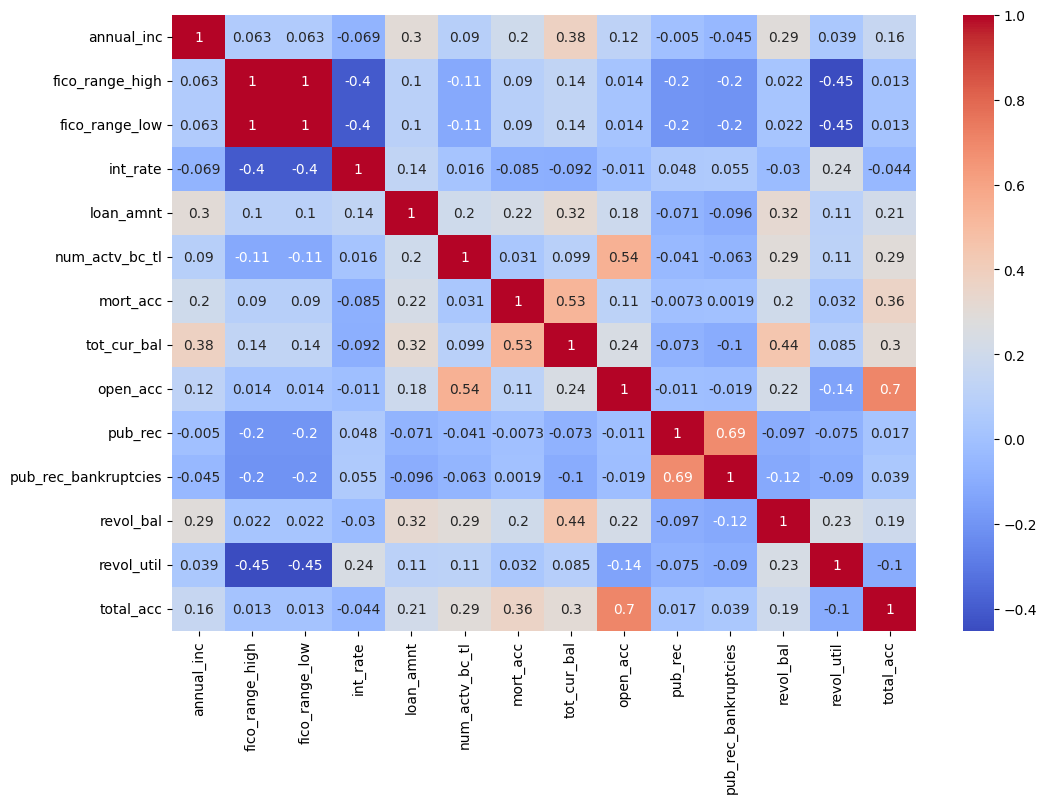

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(data.select_dtypes(include = np.number).corr(), cmap='coolwarm', annot=True)

<Axes: xlabel='emp_length', ylabel='loan_status'>

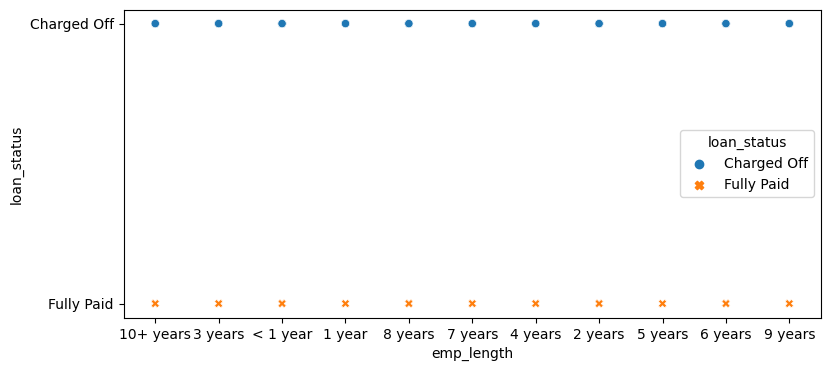

In [ ]:
plt.figure(figsize=(9,4))
categorical_columns = ['emp_length', 'loan_status']
sns.scatterplot(
    x=categorical_columns[0],
    y=categorical_columns[1],
    data=data,
    hue='loan_status',
    style='loan_status',
)




<Axes: xlabel='open_acc', ylabel='num_actv_bc_tl'>

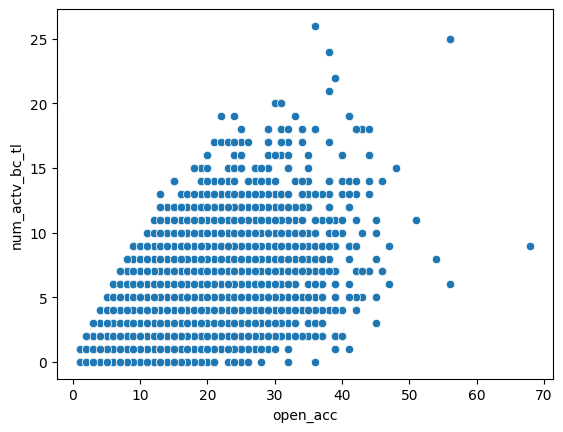

In [ ]:
sns.scatterplot(data=data,x='open_acc',y='num_actv_bc_tl')

<Axes: xlabel='tot_cur_bal', ylabel='mort_acc'>

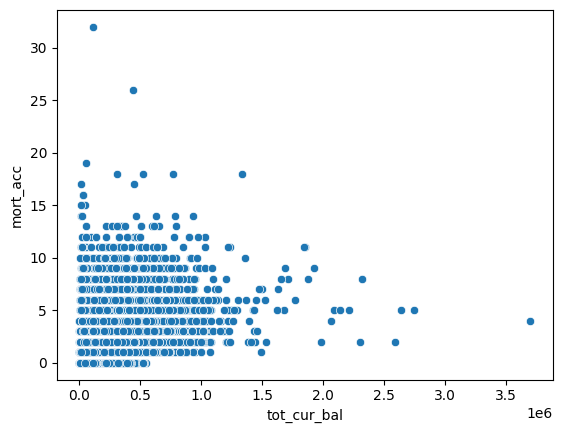

In [ ]:
sns.scatterplot(data=data,x='tot_cur_bal',y='mort_acc')

In [ ]:
#num_actv_bc_tl vs open_account

data.groupby("open_acc")["num_actv_bc_tl"].transform(lambda x: x.fillna(x.mean()))

0         1.0
1         4.0
2         4.0
3         4.0
4        14.0
         ... 
19995     1.0
19996     2.0
19997     2.0
19998     1.0
19999     6.0
Name: num_actv_bc_tl, Length: 50004, dtype: float64

In [ ]:
data.groupby("mort_acc")["tot_cur_bal"].transform(lambda x: x.fillna(x.mean()))

0        319479.0
1         19944.0
2         23199.0
3         72651.0
4         64631.0
           ...   
19995     30397.0
19996    494439.0
19997    284915.0
19998      8205.0
19999     48212.0
Name: tot_cur_bal, Length: 50004, dtype: float64

In [ ]:
data.groupby("tot_cur_bal")["mort_acc"].transform(lambda x: x.fillna(x.mean()))

0        1.0
1        0.0
2        2.0
3        1.0
4        7.0
        ... 
19995    0.0
19996    5.0
19997    4.0
19998    0.0
19999    0.0
Name: mort_acc, Length: 50004, dtype: float64

In [ ]:
#Custom transformer for dealing null values in mor_acc, tot_cur_bal and tot_cur_bal
class mean_null_values(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Perform any necessary setup or calculations here based on the input data X
        return self

    def transform(self, X, y=None):
        X = X.copy()

        X.groupby("open_acc")["num_actv_bc_tl"].transform(lambda x: x.fillna(x.mean()))





        return X

In [ ]:
a = Pipeline(steps=[
    ("a",mean_null_values())
])

In [ ]:
b=ColumnTransformer(transformers=[
    ("r",a,['num_actv_bc_tl','open_acc'])
])

In [ ]:
b.fit_transform(data)

array([[ 1.,  7.],
       [ 4.,  5.],
       [ 4.,  7.],
       ...,
       [ 2., 10.],
       [ 1.,  9.],
       [ 6., 13.]])

In [ ]:
#Custom transformer for dealing null values in mor_acc, tot_cur_bal and tot_cur_bal
class tol_cur_bal_mort_acc():
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['mort_acc']=X_copy.groupby('total_acc')['mort_acc'].transform(lambda x: x.fillna(x.median()))
        X_copy['tot_cur_bal']=X_copy.groupby('mort_acc')['total_acc'].transform(lambda x: x.fillna(x.mean()))

        return X_copy

In [ ]:
x =  Pipeline(steps = [
    ("x", tol_cur_bal_mort_acc())
])

In [ ]:
y = ColumnTransformer(transformers = [
    ('z',x,['total_acc','mort_acc'])
])

In [ ]:
y.fit_transform(data)

array([[ 8.,  1.,  8.],
       [12.,  0., 12.],
       [16.,  2., 16.],
       ...,
       [29.,  4., 29.],
       [19.,  0., 19.],
       [19.,  0., 19.]])

In [ ]:
data.isna().sum()

addr_state                  0
annual_inc                  0
earliest_cr_line            0
emp_length               2995
emp_title                3262
fico_range_high             1
fico_range_low              1
grade                       1
home_ownership              1
application_type            1
initial_list_status         1
int_rate                    1
loan_amnt                   1
num_actv_bc_tl           2510
mort_acc                 1754
tot_cur_bal              2510
open_acc                    1
pub_rec                     1
pub_rec_bankruptcies       24
purpose                     1
revol_bal                   1
revol_util                 37
sub_grade                   1
term                        1
title                     602
total_acc                   1
verification_status         1
loan_status             20001
dtype: int64

**Outliers**

In [ ]:
'''#Script to find the outliers
for col_name in data.select_dtypes(include=np.number).columns[:-1]:
    print('\n',col_name.title(),'\n')
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3 - q1

    low = q1-1.5*iqr
    high = q3+1.5*iqr
    outliers = data.loc[(data[col_name] < low) | (data[col_name] > high), col_name]
    #print("Outliers are: ",'\n',data.loc[(data[col_name] < low) | (data[col_name] > high), col_name])
    print('lower_bound of ',col_name,' is ', low)
    print('upper_bound of ',col_name,' is ', high)
    print('Outliers on',col_name, 'is',outliers.shape[0])
    print("***********************************************")'''


'#Script to find the outliers\nfor col_name in data.select_dtypes(include=np.number).columns[:-1]:\n    print(\'\n\',col_name.title(),\'\n\')\n    q1 = data[col_name].quantile(0.25)\n    q3 = data[col_name].quantile(0.75)\n    iqr = q3 - q1\n\n    low = q1-1.5*iqr\n    high = q3+1.5*iqr\n    outliers = data.loc[(data[col_name] < low) | (data[col_name] > high), col_name]\n    #print("Outliers are: ",\'\n\',data.loc[(data[col_name] < low) | (data[col_name] > high), col_name])\n    print(\'lower_bound of \',col_name,\' is \', low)\n    print(\'upper_bound of \',col_name,\' is \', high)\n    print(\'Outliers on\',col_name, \'is\',outliers.shape[0])\n    print("***********************************************")'

In [ ]:
#Detecting outlier with z-score
'''outliers=[]
def detect_outlier(data):

    threshold=3
    mean_1 = np.mean(data)
    std_1 = np.std(data)


    for y in data:
        z_score= (y - mean_1)/std_1
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers'''

'outliers=[]\ndef detect_outlier(data):\n\n    threshold=3\n    mean_1 = np.mean(data)\n    std_1 = np.std(data)\n\n\n    for y in data:\n        z_score= (y - mean_1)/std_1\n        if np.abs(z_score) > threshold:\n            outliers.append(y)\n    return outliers'

In [ ]:
'''data.select_dtypes(include=np.number).apply(detect_outlier)'''

'data.select_dtypes(include=np.number).apply(detect_outlier)'

In [ ]:
'''for i in data.select_dtypes(include=np.number).columns:
    print(i)
    Q1=data[i].quantile(0.25)
    Q3=data[i].quantile(0.75)
    IQR=Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[i] < lower_bound) | (data[i] > upper_bound)]
    print('lower_bound of ',i,' is ', lower_bound)
    print('upper_bound of ',i,' is ', upper_bound)
    print('Outliers on Feature ',i, 'is',outliers.shape[0])
    print("***********************************************")'''

'for i in data.select_dtypes(include=np.number).columns:\n    print(i)\n    Q1=data[i].quantile(0.25)\n    Q3=data[i].quantile(0.75)\n    IQR=Q3-Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n\n    outliers = data[(data[i] < lower_bound) | (data[i] > upper_bound)]\n    print(\'lower_bound of \',i,\' is \', lower_bound)\n    print(\'upper_bound of \',i,\' is \', upper_bound)\n    print(\'Outliers on Feature \',i, \'is\',outliers.shape[0])\n    print("***********************************************")'

# Feature Engineering

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_inc,50004.0,76088.986073,74613.745283,0.00,45575.50,65000.00,90000.00,9522972.00
fico_range_high,50003.0,699.855049,31.644476,664.00,674.00,694.00,714.00,850.00
fico_range_low,50003.0,695.854949,31.644004,660.00,670.00,690.00,710.00,845.00
int_rate,50003.0,13.274260,4.768662,5.31,9.75,12.79,16.01,30.99
loan_amnt,50003.0,14400.528468,8756.185331,900.00,7800.00,12000.00,20000.00,40000.00
num_actv_bc_tl,47494.0,3.631069,2.241516,0.00,2.00,3.00,5.00,26.00
mort_acc,48250.0,1.663399,1.979125,0.00,0.00,1.00,3.00,32.00
tot_cur_bal,47494.0,141234.915631,158024.425016,0.00,29554.50,80548.50,210917.75,3701271.00
open_acc,50003.0,11.581265,5.459939,1.00,8.00,11.00,14.00,68.00
pub_rec,50003.0,0.213787,0.573933,0.00,0.00,0.00,0.00,15.00


In [ ]:
data.head(5)

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status
0,CO,85000.0,Jul-1997,10+ years,Deputy,744.0,740.0,E,MORTGAGE,Individual,...,0.0,debt_consolidation,5338.0,93.6,E1,60 months,Debt consolidation,8.0,Source Verified,Charged Off
1,CA,40000.0,Apr-1987,10+ years,Department of Veterans Affairs,724.0,720.0,B,RENT,Individual,...,0.0,debt_consolidation,19944.0,60.3,B1,36 months,Credit Loan,12.0,Verified,Fully Paid
2,FL,60000.0,Aug-2007,10+ years,Marble polishing,679.0,675.0,B,MORTGAGE,Individual,...,0.0,debt_consolidation,23199.0,88.5,B5,36 months,Debt consolidation,16.0,Source Verified,Fully Paid
3,IL,100742.0,Sep-1980,10+ years,printer,664.0,660.0,B,MORTGAGE,Individual,...,0.0,debt_consolidation,18425.0,69.0,B2,36 months,Debt consolidation,19.0,Source Verified,Fully Paid
4,MD,80000.0,Jul-1999,10+ years,Southern Mgmt,669.0,665.0,F,RENT,Individual,...,0.0,debt_consolidation,34370.0,90.0,F5,60 months,Debt Connsolidation,59.0,Verified,Fully Paid


In [ ]:
#data_eda['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
#data_eda['earliest_cr_line_Month'] = data_eda['earliest_cr_line'].dt.month
#data_eda['earliest_cr_line_Year'] = data_eda['earliest_cr_line'].dt.year
#data_eda.drop(columns='earliest_cr_line',inplace=True)

#data_eda['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
#data_eda['earliest_cr_line_Month'] = data_eda['earliest_cr_line'].dt.month
#data_eda['earliest_cr_line_Year'] = data_eda['earliest_cr_line'].dt.year
#data_eda.drop(columns='earliest_cr_line',inplace=True)
#data_eda["emp_length_new"]=data_eda["emp_length"].astype(str).apply(lambda text: int(re.search(r'\d+', text).group()) if re.search(r'\d+', text) else None)
#data_eda.drop(columns='emp_length',inplace=True)

#data_eda['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
#data_eda['earliest_cr_line_Month'] = data_eda['earliest_cr_line'].dt.month
#data_eda['earliest_cr_line_Year'] = data_eda['earliest_cr_line'].dt.year
#data_eda.drop(columns='earliest_cr_line',inplace=True)
#data_eda["emp_length_new"]=data_eda["emp_length"].astype(str).apply(lambda text: int(re.search(r'\d+', text).group()) if re.search(r'\d+', text) else None)
#data_eda.drop(columns='emp_length',inplace=True)
#data_eda['term_modified'] = data_eda["term"].apply(lambda x: x.split(" ")[1])
#data_eda.drop(columns = 'term', inplace=True)
#data_eda['emp_title_modified']=data_eda['emp_title'].astype(str).apply(lambda s: re.sub(r'[^\w\s]', '', s) )
#data_eda.drop(columns='emp_title',inplace=True)

In [ ]:
data["term"]

0         60 months
1         36 months
2         36 months
3         36 months
4         60 months
            ...    
19995     36 months
19996     60 months
19997     36 months
19998     36 months
19999     60 months
Name: term, Length: 50004, dtype: object

In [ ]:
data["term"].astype(str).apply(lambda x:x[:3])

0         60
1         36
2         36
3         36
4         60
        ... 
19995     36
19996     60
19997     36
19998     36
19999     60
Name: term, Length: 50004, dtype: object

In [ ]:
class Emp_Length_Term(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Perform any necessary setup or calculations here based on the input data X
        return self

    def transform(self, X, y=None):
        X = X.copy()

        X['term']=X['term'].astype(str).apply(lambda x: x[:3])
        #X['term']=X['term'].astype(int)



        #X['emp_title'] = X['emp_title'].astype(str).apply(lambda s: re.sub(r'[^\w\s]', '', s))


        # X = X.drop(columns=['earliest_cr_line', 'emp_length', 'emp_title'])

        return X


In [ ]:
p=Pipeline(steps=[
    ("ear_line",Emp_Length_Term())
])

In [ ]:

c=ColumnTransformer(transformers=[
    ("ear_line_test",p,['term'])
])

In [ ]:
c.fit_transform(data)

array([[' 60'],
       [' 36'],
       [' 36'],
       ...,
       [' 36'],
       [' 36'],
       [' 60']], dtype=object)

In [ ]:
data["earliest_cr_line"]

0        Jul-1997
1        Apr-1987
2        Aug-2007
3        Sep-1980
4        Jul-1999
           ...   
19995    Sep-2010
19996    Dec-1998
19997    May-1996
19998    Mar-2003
19999    Apr-1994
Name: earliest_cr_line, Length: 50004, dtype: object

In [ ]:
class earliest_cr_line(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()

        X_copy['earliest_cr_line'] = pd.to_datetime(X_copy['earliest_cr_line'])
        X_copy['earliest_cr_line'] = X_copy['earliest_cr_line'].dt.year



        return X_copy

In [ ]:

p=Pipeline(steps=[
    ("x",earliest_cr_line())
])

In [ ]:

c=ColumnTransformer(transformers=[
    ("s",p,['earliest_cr_line'])
])

In [ ]:
c.fit_transform(data)

array([[1997],
       [1987],
       [2007],
       ...,
       [1996],
       [2003],
       [1994]])

In [ ]:
class verification_status():
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['verification_status']=X_copy["verification_status"].str.replace("Source Verified","Verified")
        return X_copy

In [ ]:
pipeline_num=Pipeline(steps=[
    ("earliest_cr_line",earliest_cr_line()),
	  ("term",Emp_Length_Term()),
    ("num_actv_bc_tl",mean_null_values()),
    ("mort_acc_total_bal",tol_cur_bal_mort_acc()),
    ("impute",SimpleImputer(strategy='median')),
    ("scale",StandardScaler())
])

In [ ]:
num_cols = ['earliest_cr_line','annual_inc', 'fico_range_high', 'fico_range_low', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc','term'
          ]

In [ ]:
t=ColumnTransformer(transformers=[
    ("pipe",pipeline_num,['earliest_cr_line','annual_inc', 'fico_range_high', 'fico_range_low', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc','term'
          ])
])

In [ ]:
t

ColumnTransformer(transformers=[('pipe',
                                 Pipeline(steps=[('earliest_cr_line',
                                                  earliest_cr_line()),
                                                 ('term', Emp_Length_Term()),
                                                 ('num_actv_bc_tl',
                                                  mean_null_values()),
                                                 ('mort_acc_total_bal',
                                                  <__main__.tol_cur_bal_mort_acc object at 0x7ef243234c10>),
                                                 ('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['earliest_cr_line', 'annual_inc',
                                  'fico_range_high', 'fico_range_low',
                                  'int_rate', 'loan_amnt', 'num_actv_bc_tl',
                                  'mort_acc', 'tot_cur_bal', 'open_acc',
                                  'pub_rec', 'pub_rec_bankruptcies',
                                  'revol_bal', 'revol_util', 'total_acc',
                                  'term'])])

In [ ]:
 b = pipeline_num.fit_transform(data[num_cols])

In [ ]:
c = pd.DataFrame(b , columns = num_cols)

In [ ]:
c

,earliest_cr_line,annual_inc,fico_range_high,fico_range_low,int_rate,loan_amnt,num_actv_bc_tl,mort_acc,tot_cur_bal,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,term
0,-0.220076,0.119430,1.395060,1.395084,1.198630,0.419657,-1.187559,-0.326513,-1.412566,-0.839083,-0.372494,-0.355687,-0.484790,1.699766,-1.412566,1.772417
1,-1.523498,-0.483682,0.763026,0.763040,-0.653079,-0.639615,0.183022,-0.838000,-1.079623,-1.205395,-0.372494,-0.355687,0.166382,0.342809,-1.079623,-0.564201
2,1.083347,-0.215632,-0.659052,-0.659058,-0.378363,0.411091,0.183022,0.184975,-0.746679,-0.839083,-0.372494,-0.355687,0.311498,1.491944,-0.746679,-0.564201
3,-2.435894,0.330412,-1.133077,-1.133091,-0.862785,0.639505,0.183022,-0.326513,-0.496972,0.076696,-0.372494,-0.355687,0.098661,0.697329,-0.496972,-0.564201
4,0.040609,0.052417,-0.975069,-0.975080,2.213610,2.352613,4.751625,2.742413,2.832464,2.091410,-0.372494,-0.355687,0.809529,1.553068,2.832464,1.772417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49999,1.474373,-0.503786,-0.659052,-0.659058,0.900847,-0.502566,-1.187559,-0.838000,-1.246095,-0.289616,-0.372494,-0.355687,-0.463480,0.330584,-1.246095,-0.564201
50000,-0.089733,0.052417,-0.817060,-0.817069,1.183951,0.453919,-0.730699,1.719438,0.418623,-0.472772,-0.372494,-0.355687,-0.103699,0.945901,0.418623,1.772417
50001,-0.350418,0.253455,0.921034,0.921051,-0.430790,2.352613,-0.730699,1.207950,0.335387,-0.289616,-0.372494,-0.355687,1.201677,0.359109,0.335387,-0.564201
50002,0.561978,-0.550695,3.449171,3.449226,-1.129113,-1.073602,-1.187559,-0.838000,-0.496972,-0.472772,-0.372494,-0.355687,-0.673285,-1.935086,-0.496972,-0.564201


In [ ]:
cat_cols=["home_ownership","application_type","initial_list_status","purpose","sub_grade","verification_status"]


In [ ]:
pipeline_cat=Pipeline(steps=[
    ("ver",verification_status()),
    ("ohe",OneHotEncoder(sparse=False,drop='first'))
])

In [ ]:
t=ColumnTransformer(transformers=[
    ("pipe",pipeline_cat,["home_ownership","application_type","initial_list_status","purpose","sub_grade","verification_status"
          ])
])

In [ ]:
pipeline_cat.fit_transform(data[cat_cols])

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [ ]:
prepocess=ColumnTransformer(transformers=[
    ("num",pipeline_num,num_cols),
    ("cat",pipeline_cat,cat_cols)
])

In [ ]:
pipeline_full = Pipeline(steps=[
    ("final",prepocess)
])

In [ ]:
pipeline_full

Pipeline(steps=[('final',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('earliest_cr_line',
                                                                   earliest_cr_line()),
                                                                  ('term',
                                                                   Emp_Length_Term()),
                                                                  ('num_actv_bc_tl',
                                                                   mean_null_values()),
                                                                  ('mort_acc_total_bal',
                                                                   <__main__.tol_cur_bal_mort_acc object at 0x7ef243234c10>),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['earliest_cr_l...
                                                   'tot_cur_bal', 'open_acc',
                                                   'pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'term']),
                                                 ('cat',
                                                  Pipeline(steps=[('ver',
                                                                   <__main__.verification_status object at 0x7ef243235420>),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['home_ownership',
                                                   'application_type',
                                                   'initial_list_status',
                                                   'purpose', 'sub_grade',
                                                   'verification_status'])]))])

In [ ]:
pipeline_full.fit_transform(data)

array([[-0.22007568,  0.11942978,  1.39505977, ...,  0.        ,
         1.        ,  0.        ],
       [-1.52349803, -0.48368229,  0.76302552, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.08334666, -0.21563248, -0.65905156, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.35041792,  0.25345468,  0.92103408, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56197772, -0.55069474,  3.4491711 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.61110239, -0.60832545, -1.13307725, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
test=pd.DataFrame(pipeline_full.fit_transform(data))

In [ ]:
test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,-0.220076,0.11943,1.39506,1.395084,1.19863,0.419657,-1.187559,-0.326513,-1.412566,-0.839083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
pipeline_mdl = Pipeline([
    ("preprocess",pipeline_full),

])

In [ ]:
data["loan_status"]

0        Charged Off
1         Fully Paid
2         Fully Paid
3         Fully Paid
4         Fully Paid
            ...     
19995            NaN
19996            NaN
19997            NaN
19998            NaN
19999            NaN
Name: loan_status, Length: 50004, dtype: object

In [ ]:
train[['loan_status']]=train[['loan_status']].replace({"Charged Off":1,"Fully Paid":0})

In [ ]:
X=train.drop(columns='loan_status')
y=train[['loan_status']].fillna(train["loan_status"].mode()[0])

In [ ]:
y

,loan_status
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
29999,0.0
30000,1.0
30001,0.0
30002,0.0


In [ ]:
ros = RandomOverSampler(random_state=42)

In [ ]:
X_,y_ = ros.fit_resample(X,y)

In [ ]:
y_.value_counts()

loan_status
0.0            24022
1.0            24022
dtype: int64

In [ ]:
train_X, test_X, train_y,test_y = train_test_split(X_,y_,test_size=0.2,random_state=42)

In [ ]:
pipeline_mdl.fit(train_X,train_y)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('final',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('earliest_cr_line',
                                                                                    earliest_cr_line()),
                                                                                   ('term',
                                                                                    Emp_Length_Term()),
                                                                                   ('num_actv_bc_tl',
                                                                                    mean_null_values()),
                                                                                   ('mort_acc_total_bal',
                                                                                    <__main__.tol_cur_bal_mort_acc object at 0x7ef243234c10>),
                                                                                   ('impute',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scale',
                                                                                    Stand...
                                                                    'open_acc',
                                                                    'pub_rec',
                                                                    'pub_rec_bankruptcies',
                                                                    'revol_bal',
                                                                    'revol_util',
                                                                    'total_acc',
                                                                    'term']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('ver',
                                                                                    <__main__.verification_status object at 0x7ef243235420>),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  sparse=False,
                                                                                                  sparse_output=False))]),
                                                                   ['home_ownership',
                                                                    'application_type',
                                                                    'initial_list_status',
                                                                    'purpose',
                                                                    'sub_grade',
                                                                    'verification_status'])]))]))])

In [ ]:
'''pipe_lr = Pipeline([
    ('preprocess',pipeline_mdl),
    ('lr',LogisticRegression())
])

pipe_dt = Pipeline([
    ('preprocess',pipeline_mdl),
    ('dt',DecisionTreeClassifier())
])

pipe_knn = Pipeline([
    ('preprocess',pipeline_mdl),
    ('knn',KNeighborsClassifier())
])

pipe_rf = Pipeline([
    ('preprocess',pipeline_mdl),
    ('rf',RandomForestClassifier())
])'''

In [ ]:
'''grid_param_lr = [{'lr__penalty':['l2']}]
grid_param_knn = [{'knn__n_neighbors':[10,15]}]
grid_param_dt = [{'dt__max_depth':[5,10]}]
grid_param_rf = [{'rf__max_depth':[5,10]}]'''

In [ ]:
# GridSearchCV
'''gridsrc_lr = GridSearchCV(pipe_lr, param_grid=grid_param_lr, scoring='r2', cv=2)
gridsrc_knn = GridSearchCV(pipe_knn, param_grid=grid_param_knn, scoring='r2', cv=2)
gridsrc_dt = GridSearchCV(pipe_dt, param_grid=grid_param_dt, scoring='r2', cv=2)
gridsrc_rf = GridSearchCV(pipe_rf, param_grid=grid_param_rf, scoring='r2', cv=2)'''

In [ ]:
'''result_acc = {}
models = []
iter_mdl = [gridsrc_lr,  gridsrc_knn, gridsrc_dt, gridsrc_rf]
mdl_idx = {0:'Log_reg', 1:'Knn', 2:'DecisionTree', 3:'RandomForest'}

for id, model in enumerate(iter_mdl):
  model.fit(train_X, train_y)
  print(model.best_params_)
  print(model.best_score_)

  models.append(model.best_estimator_)
  result_acc[id] = model.best_score_'''

In [ ]:
pipe_lr = Pipeline([
    ('preprocess',pipeline_mdl),
    ('lr',LogisticRegression())
])

pipe_dt = Pipeline([
    ('preprocess',pipeline_mdl),
    ('dt',DecisionTreeClassifier())
])

pipe_knn = Pipeline([
    ('preprocess',pipeline_mdl),
    ('knn',KNeighborsClassifier())
])

pipe_rf = Pipeline([
    ('preprocess',pipeline_mdl),
    ('rf',RandomForestClassifier())
])

In [ ]:
pipe_lr.fit(train_X,train_y)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  Pipeline(steps=[('final',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('earliest_cr_line',
                                                                                                     earliest_cr_line()),
                                                                                                    ('term',
                                                                                                     Emp_Length_Term()),
                                                                                                    ('num_actv_bc_tl',
                                                                                                     mean_null_values()),
                                                                                                    ('mort_acc_total_bal',
                                                                                                     <__main__.tol_cur_bal_mort_acc object at 0x7ef243234c10>),
                                                                                                    ('impute',
                                                                                                     SimpleImputer(stra...
                                                                                     'pub_rec_bankruptcies',
                                                                                     'revol_bal',
                                                                                     'revol_util',
                                                                                     'total_acc',
                                                                                     'term']),
                                                                                   ('cat',
                                                                                    Pipeline(steps=[('ver',
                                                                                                     <__main__.verification_status object at 0x7ef243235420>),
                                                                                                    ('ohe',
                                                                                                     OneHotEncoder(drop='first',
                                                                                                                   sparse=False,
                                                                                                                   sparse_output=False))]),
                                                                                    ['home_ownership',
                                                                                     'application_type',
                                                                                     'initial_list_status',
                                                                                     'purpose',
                                                                                     'sub_grade',
                                                                                     'verification_status'])]))]))])),
                ('lr', LogisticRegression())])

In [ ]:
 pred_val_y = pipe_lr.predict(test_X)

In [ ]:
print('val log_loss:', log_loss(test_y, pred_val_y))
print('val accuracy_score:', accuracy_score(test_y, pred_val_y))
print('val conf.matrix: \n', confusion_matrix(test_y, pred_val_y))
print('val classification: \n', classification_report(test_y, pred_val_y))

val log_loss: 12.83227580853052
val accuracy_score: 0.6439796024560308
val conf.matrix: 
 [[2946 1887]
 [1534 3242]]
val classification: 
               precision    recall  f1-score   support

         0.0       0.66      0.61      0.63      4833
         1.0       0.63      0.68      0.65      4776

    accuracy                           0.64      9609
   macro avg       0.64      0.64      0.64      9609
weighted avg       0.64      0.64      0.64      9609



In [ ]:
pipe_dt.fit(train_X,train_y)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  Pipeline(steps=[('final',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('earliest_cr_line',
                                                                                                     earliest_cr_line()),
                                                                                                    ('term',
                                                                                                     Emp_Length_Term()),
                                                                                                    ('num_actv_bc_tl',
                                                                                                     mean_null_values()),
                                                                                                    ('mort_acc_total_bal',
                                                                                                     <__main__.tol_cur_bal_mort_acc object at 0x7ef243234c10>),
                                                                                                    ('impute',
                                                                                                     SimpleImputer(stra...
                                                                                     'pub_rec_bankruptcies',
                                                                                     'revol_bal',
                                                                                     'revol_util',
                                                                                     'total_acc',
                                                                                     'term']),
                                                                                   ('cat',
                                                                                    Pipeline(steps=[('ver',
                                                                                                     <__main__.verification_status object at 0x7ef243235420>),
                                                                                                    ('ohe',
                                                                                                     OneHotEncoder(drop='first',
                                                                                                                   sparse=False,
                                                                                                                   sparse_output=False))]),
                                                                                    ['home_ownership',
                                                                                     'application_type',
                                                                                     'initial_list_status',
                                                                                     'purpose',
                                                                                     'sub_grade',
                                                                                     'verification_status'])]))]))])),
                ('dt', DecisionTreeClassifier())])

In [ ]:
pred_val_dt_y = pipe_dt.predict(test_X)
print('val log_loss:', log_loss(test_y, pred_val_dt_y))
print('val accuracy_score:', accuracy_score(test_y, pred_val_dt_y))
print('val conf.matrix: \n', confusion_matrix(test_y, pred_val_dt_y))
print('val classification: \n', classification_report(test_y, pred_val_dt_y))

val log_loss: 4.433718212710634
val accuracy_score: 0.8769903215735249
val conf.matrix: 
 [[3793 1040]
 [ 142 4634]]
val classification: 
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.87      4833
         1.0       0.82      0.97      0.89      4776

    accuracy                           0.88      9609
   macro avg       0.89      0.88      0.88      9609
weighted avg       0.89      0.88      0.88      9609



In [ ]:
pipe_knn.fit(train_X,train_y)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  Pipeline(steps=[('final',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('earliest_cr_line',
                                                                                                     earliest_cr_line()),
                                                                                                    ('term',
                                                                                                     Emp_Length_Term()),
                                                                                                    ('num_actv_bc_tl',
                                                                                                     mean_null_values()),
                                                                                                    ('mort_acc_total_bal',
                                                                                                     <__main__.tol_cur_bal_mort_acc object at 0x7ef243234c10>),
                                                                                                    ('impute',
                                                                                                     SimpleImputer(stra...
                                                                                     'pub_rec_bankruptcies',
                                                                                     'revol_bal',
                                                                                     'revol_util',
                                                                                     'total_acc',
                                                                                     'term']),
                                                                                   ('cat',
                                                                                    Pipeline(steps=[('ver',
                                                                                                     <__main__.verification_status object at 0x7ef243235420>),
                                                                                                    ('ohe',
                                                                                                     OneHotEncoder(drop='first',
                                                                                                                   sparse=False,
                                                                                                                   sparse_output=False))]),
                                                                                    ['home_ownership',
                                                                                     'application_type',
                                                                                     'initial_list_status',
                                                                                     'purpose',
                                                                                     'sub_grade',
                                                                                     'verification_status'])]))]))])),
                ('knn', KNeighborsClassifier())])

In [ ]:
pred_val_knn_y = pipe_dt.predict(test_X)
print('val log_loss:', log_loss(test_y, pred_val_knn_y))
print('val accuracy_score:', accuracy_score(test_y, pred_val_knn_y))
print('val conf.matrix: \n', confusion_matrix(test_y, pred_val_knn_y))
print('val classification: \n', classification_report(test_y, pred_val_knn_y))

val log_loss: 4.433718212710634
val accuracy_score: 0.8769903215735249
val conf.matrix: 
 [[3793 1040]
 [ 142 4634]]
val classification: 
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.87      4833
         1.0       0.82      0.97      0.89      4776

    accuracy                           0.88      9609
   macro avg       0.89      0.88      0.88      9609
weighted avg       0.89      0.88      0.88      9609



In [ ]:
pipe_rf.fit(train_X,train_y)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  Pipeline(steps=[('final',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('earliest_cr_line',
                                                                                                     earliest_cr_line()),
                                                                                                    ('term',
                                                                                                     Emp_Length_Term()),
                                                                                                    ('num_actv_bc_tl',
                                                                                                     mean_null_values()),
                                                                                                    ('mort_acc_total_bal',
                                                                                                     <__main__.tol_cur_bal_mort_acc object at 0x7ef243234c10>),
                                                                                                    ('impute',
                                                                                                     SimpleImputer(stra...
                                                                                     'pub_rec_bankruptcies',
                                                                                     'revol_bal',
                                                                                     'revol_util',
                                                                                     'total_acc',
                                                                                     'term']),
                                                                                   ('cat',
                                                                                    Pipeline(steps=[('ver',
                                                                                                     <__main__.verification_status object at 0x7ef243235420>),
                                                                                                    ('ohe',
                                                                                                     OneHotEncoder(drop='first',
                                                                                                                   sparse=False,
                                                                                                                   sparse_output=False))]),
                                                                                    ['home_ownership',
                                                                                     'application_type',
                                                                                     'initial_list_status',
                                                                                     'purpose',
                                                                                     'sub_grade',
                                                                                     'verification_status'])]))]))])),
                ('rf', RandomForestClassifier())])

In [ ]:
pred_val_rf_y = pipe_dt.predict(test_X)
print('val log_loss:', log_loss(test_y, pred_val_rf_y))
print('val accuracy_score:', accuracy_score(test_y, pred_val_rf_y))
print('val conf.matrix: \n', confusion_matrix(test_y, pred_val_rf_y))
print('val classification: \n', classification_report(test_y, pred_val_rf_y))

val log_loss: 4.433718212710634
val accuracy_score: 0.8769903215735249
val conf.matrix: 
 [[3793 1040]
 [ 142 4634]]
val classification: 
               precision    recall  f1-score   support

         0.0       0.96      0.78      0.87      4833
         1.0       0.82      0.97      0.89      4776

    accuracy                           0.88      9609
   macro avg       0.89      0.88      0.88      9609
weighted avg       0.89      0.88      0.88      9609



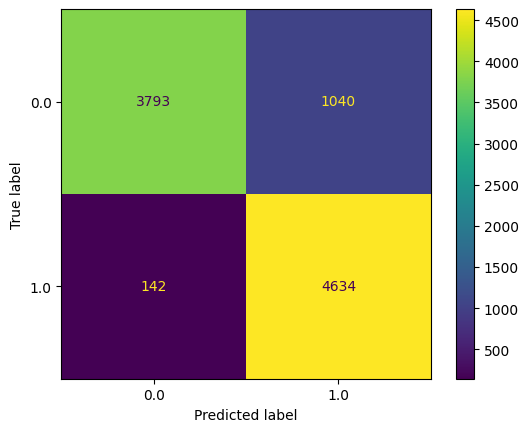

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_y,pred_val_rf_y)